In [1]:
import glob
import pandas as pd
from datetime import datetime

# Functions

In [2]:
def processHeartRate_FILE(Filename):
    
    df1=pd.read_json(Filename)
    df2=processHeartRate_DATAFRAME(df1)
    
    return df2     

In [3]:
def processHeartRate_DATAFRAME(df):
    
    df['Date'] = pd.to_datetime(df['dateTime']).dt.date
    df['Time'] = pd.to_datetime(df['dateTime']).dt.time
    
    # Copying the dict values to the dataframe, based on:
    # https://stackoverflow.com/questions/29681906/python-pandas-dataframe-from-series-of-dict
    
    temp_df = pd.DataFrame(list(df['value']))
    df['BPM']=temp_df['bpm']
    df['Confidence']=temp_df['confidence']
 
    # Remove initial, final and some other low-confidnece readings
    # Then re-index to prevent possible problems

    df=df[df[:]['Confidence']>1]  
    dfNew=df.reindex()        
    
    return dfNew

In [4]:
def calculateSummeries(df):
    Date=df.iloc[0]['Date'] # Assumes that this json is for a single date
    Duration= datetime.combine( Date, df['Time'].max() ) - datetime.combine( Date,df['Time'].min() )
    MeanBPM=round(df['BPM'].mean(),0)
    MaxBPM=round(df['BPM'].max(),0)
    
    s= str(df.iloc[0]['Date']) + ' ' + str(Duration) + ' ' + str(MeanBPM) + ' ' + str(MaxBPM)   
    Summaries.append(s)

In [5]:
# Each json heart rate file covers a day
# Identifies days with more than one activity (no data for more than 20 minutes in between)

def identifyBreak_inTime(df):
    
    breakExists=False
    for i in range(len(df)-1):
        delta=df.iloc[i+1]['dateTime'] - df.iloc[i]['dateTime']
        if (delta>pd.Timedelta("20 minutes")):
            print('BREAK ',i,df.iloc[i]['dateTime'],df.iloc[i+1]['dateTime'])
            breakExists=True
            break
    return breakExists,i

# Main

In [6]:
# Global parameters and variables

start=289           # File number to start from 
n_files=3         # Process and plot n files
n_plots=n_files

DFs=[]
Summaries=[]

In [7]:
files=glob.glob("FITBIT\heart_rate*.json")

len(files)

293

In [8]:
for i in range(start,start+n_files): 
    print('Main, i',i)
    df = processHeartRate_FILE(files[i])
        
    breakExists,breakIndex=identifyBreak_inTime(df)
    if (breakExists):
        df1=df[0:breakIndex+1]
        df2=df[breakIndex+1:]
        #df2=df2.reindex()  # Too careful?
        DFs.append(df1)
        calculateSummeries(df1)
        DFs.append(df2)
        calculateSummeries(df2)
        #df3=processHeartRate_DATAFRAME(df2)
        n_plots+=1
    else:
        DFs.append(df)
        calculateSummeries(df)

Main, i 289
Main, i 290
BREAK  863 2021-03-01 10:39:22 2021-03-01 14:32:42
Main, i 291
BREAK  1089 2021-03-02 11:17:23 2021-03-02 15:15:25


# Plot

n_plots 5


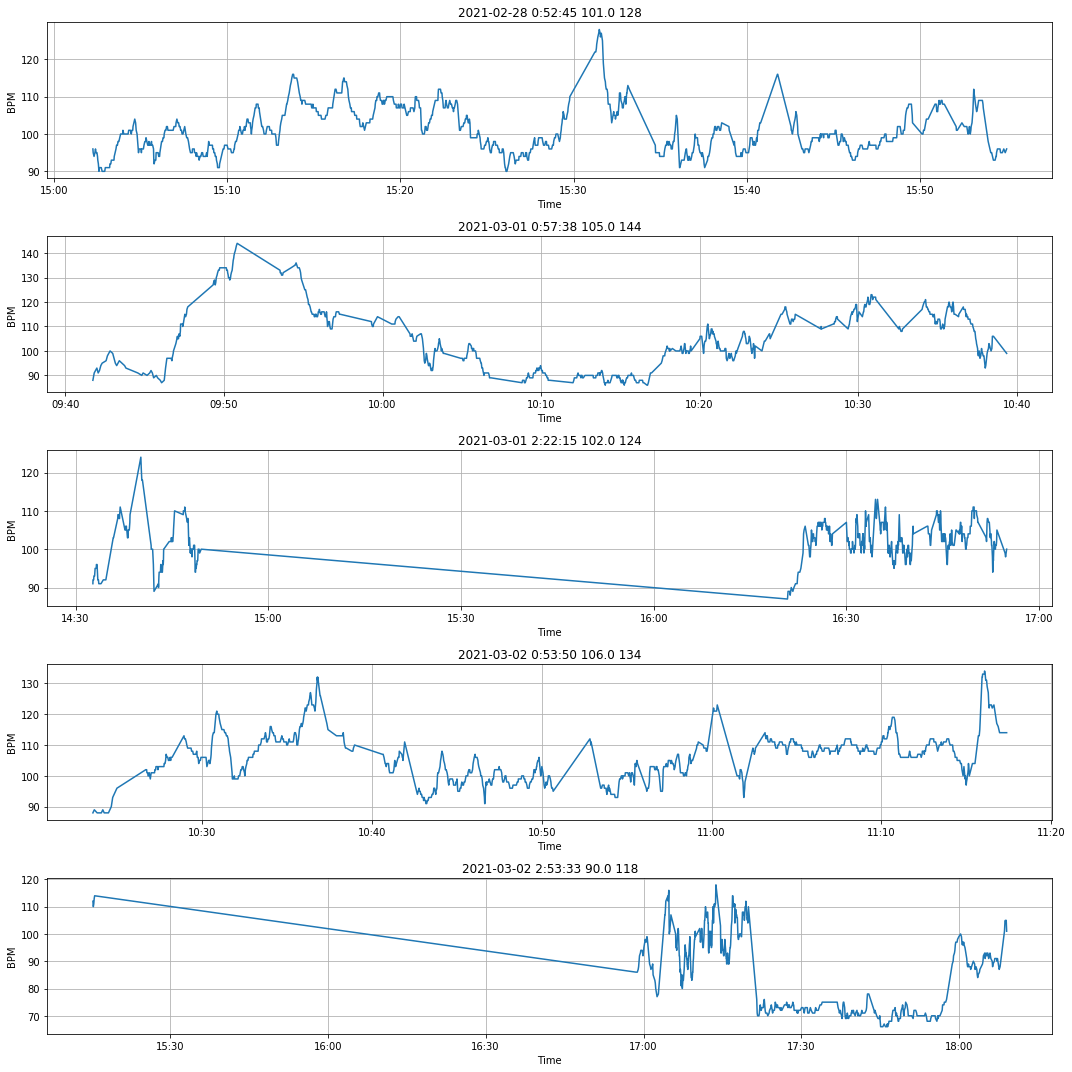

In [9]:
# From: https://matplotlib.org/stable/gallery/lines_bars_and_markers/cohere.html
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

print('n_plots',n_plots)
fig, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(15, 3*n_plots) )

myFormat = DateFormatter("%H:%M")
register_matplotlib_converters(myFormat)

for i in range(n_plots):
    df=DFs[i]
    #print('Plot i',i)
    axs[i].plot(df['dateTime'], df['BPM'])
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('BPM')
    axs[i].set_title( Summaries[i] )
    axs[i].grid(True)
    axs[i].xaxis.set_major_formatter(myFormat)
            
fig.tight_layout()
plt.show()

In [ ]:
df=DFs[2]
df=df[df[:]['confidence']>1]
df=df.reindex()   
df